# Libraries

In [57]:
# Data set 
from tensorflow.keras.datasets import mnist
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Logistic Regression
import numpy as np
from sklearn.linear_model import LogisticRegression
# Tenser Flow  for RMS Promp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Accuracy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# hyper parameters tunng 
from keras_tuner import RandomSearch
import kerastuner as kt
from keras.optimizers import Adam


# Load MNIST Data set 

In [79]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Data Set Overview

Before normalization:
Max pixel value: 255
Min pixel value: 0


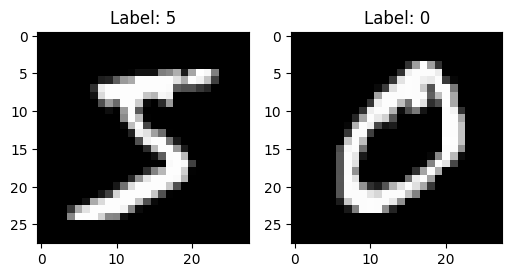

In [80]:
print("Before normalization:")
print("Max pixel value:", train_images.max())
print("Min pixel value:", train_images.min())
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(train_images[0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.subplot(1, 2, 2)
plt.imshow(train_images[1], cmap='gray')
plt.title(f"Label: {train_labels[1]}")

plt.show()

# -----------------------------Pre PRocessing------------------------------

### Normalization


After normalization:
Max pixel value: 1.0
Min pixel value: 0.0


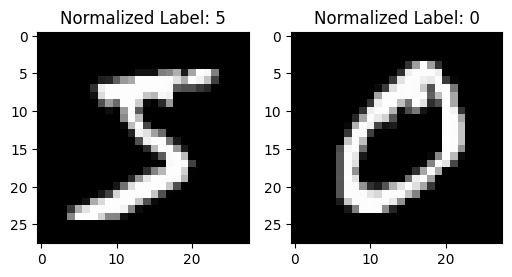

In [81]:

train_images_normalized = train_images.astype('float32') / 255.0
test_images_normalized = test_images.astype('float32') / 255.0
print("\nAfter normalization:")
print("Max pixel value:", train_images_normalized.max())
print("Min pixel value:", train_images_normalized.min())
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(train_images_normalized[0], cmap='gray')
plt.title(f"Normalized Label: {train_labels[0]}")

plt.subplot(1, 2, 2)
plt.imshow(train_images_normalized[1], cmap='gray')
plt.title(f"Normalized Label: {train_labels[1]}")

plt.show()

### StandardScaler

Train images mean (after standardization): -4.987327217875759e-10
Train images std (after standardization): 0.9563164114952087


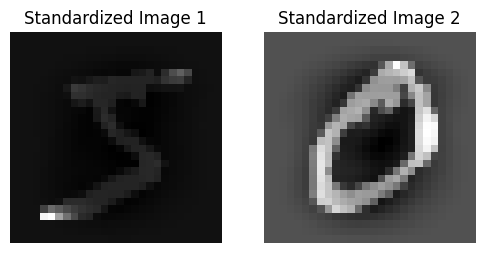

In [82]:
scaler = StandardScaler()
train_images_reshaped = train_images_normalized.reshape((train_images.shape[0], -1))
test_images_reshaped = test_images_normalized.reshape((test_images.shape[0], -1))
train_images_standardized = scaler.fit_transform(train_images_reshaped)
test_images_standardized = scaler.transform(test_images_reshaped)
print(f"Train images mean (after standardization): {train_images_standardized.mean()}")
print(f"Train images std (after standardization): {train_images_standardized.std()}")
standardized_image_1 = train_images_standardized[0].reshape(28, 28)
standardized_image_2 = train_images_standardized[1].reshape(28, 28)

plt.figure(figsize=(6, 3))
for i, img in enumerate([standardized_image_1, standardized_image_2]):
    plt.subplot(1, 2, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Standardized Image {i+1}")
    plt.axis('off')
plt.show()

### PCA

In [84]:
pca = PCA(n_components=0.95)  # Retain 95% of the variance
preprosess_train_images = pca.fit_transform(train_images_standardized)
preprocess_test_images = pca.transform(test_images_standardized)
print(f"Original number of features: {train_images_standardized.shape[1]}")
print(f"Reduced number of features after PCA (train): {preprosess_train_images.shape[1]}")
print(f"Reduced number of features after PCA (test): {preprocess_test_images.shape[1]}")


# Ensure the number of samples in train and test sets are consistent with labels
if preprosess_train_images.shape[0] != train_labels.shape[0]:
    raise ValueError(f"Training images PCA shape mismatch: {preprosess_train_images.shape[0]} vs {train_labels.shape[0]}")

if preprocess_test_images.shape[0] != test_labels.shape[0]:
    raise ValueError(f"Test images PCA shape mismatch: {preprocess_test_images.shape[0]} vs {test_labels.shape[0]}")

Original number of features: 784
Reduced number of features after PCA (train): 331
Reduced number of features after PCA (test): 331


# General functions of Logistic Regression

In [61]:
def train_log_reg(train_images, train_labels, max_iter=1000, optimizer=None, use_tensorflow=False, learning_rate=0.001, epochs=10):
    if use_tensorflow:
        # Create a simple logistic regression model using TensorFlow
        model = keras.Sequential([
            layers.Flatten(input_shape=train_images.shape[1:]),  
            layers.Dense(10, activation='softmax')  
        ])
        
        # Default optimizer is Adam if none is provided
        if optimizer is None:
            optimizer = Adam(learning_rate=learning_rate) 
        elif optimizer.lower() == 'nag':
            optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
        else:
            optimizer_class = getattr(keras.optimizers, optimizer.capitalize(), None)
            if optimizer_class is None:
                raise ValueError(f"Optimizer {optimizer} not recognized.")
            optimizer = optimizer_class(learning_rate=learning_rate)

        model.compile(optimizer=optimizer,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

        model.fit(train_images, train_labels, epochs=epochs)
        return model

    else:
        # Use scikit-learn's Logistic Regression
        if optimizer is None:
            log_reg_model = LogisticRegression(max_iter=max_iter, random_state=42)
        else:
            log_reg_model = LogisticRegression(max_iter=max_iter, solver=optimizer, random_state=42)
        
        log_reg_model.fit(train_images, train_labels)
        return log_reg_model
    
# RMSprop is tailored for deep learning scenarios handled by TensorFlow, 
# whereas scikit-learn focuses on more straightforward implementations of machine 
# learning algorithms where simpler optimizers are sufficient


In [35]:
def evaluate_log_reg(model, test_images, test_labels, use_tensorflow=False):
    if use_tensorflow:
        # For TensorFlow model, predict class probabilities
        probabilities = model.predict(test_images)
        predictions = np.argmax(probabilities, axis=1)  # Get the class with the highest probability
    else:
        # For scikit-learn model
        predictions = model.predict(test_images)  # Predictions are already class labels

    # Evaluate the model
    accuracy = accuracy_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions, average='weighted')
    recall = recall_score(test_labels, predictions, average='weighted')
    f1 = f1_score(test_labels, predictions, average='weighted')

    print(f"Model Accuracy: {accuracy:.4f}")
    print(f"Model Precision: {precision:.4f}")
    print(f"Model Recall: {recall:.4f}")
    print(f"Model F1 Score: {f1:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(test_labels, predictions))

    # Confusion Matrix
    cm = confusion_matrix(test_labels, predictions)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Visualize class separation in PCA space
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(test_images[:, 0], test_images[:, 1], c=predictions, cmap='viridis', alpha=0.5)
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.gca().add_artist(legend1)
    plt.title("PCA of Test Dataset with Logistic Regression Predictions")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar(scatter, label='Predicted Classes')
    plt.show()

    # Additional visualizations
    metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
    
    plt.figure(figsize=(10, 5))
    plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green', 'red'])
    plt.ylim(0, 1)
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.show()

    return accuracy, predictions


In [25]:
def flatten_images(train_images, test_images):
    train_images_flat = train_images.reshape(train_images.shape[0], -1)  
    test_images_flat = test_images.reshape(test_images.shape[0], -1)    
    return train_images_flat, test_images_flat

# ------------------Part a Simple Logistric regression---------------------

### without PReprocessing

c:\Users\mahma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Accuracy: 0.9204
Model Precision: 0.9203
Model Recall: 0.9204
Model F1 Score: 0.9202

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.95      0.98      0.97      1135
           2       0.92      0.89      0.90      1032
           3       0.90      0.91      0.91      1010
           4       0.93      0.92      0.93       982
           5       0.90      0.85      0.87       892
           6       0.94      0.95      0.94       958
           7       0.93      0.92      0.92      1028
           8       0.87      0.89      0.88       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



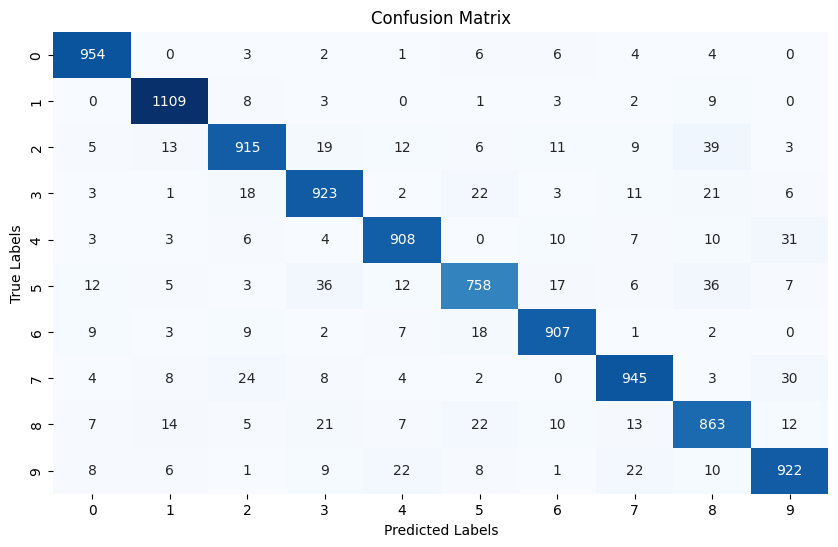

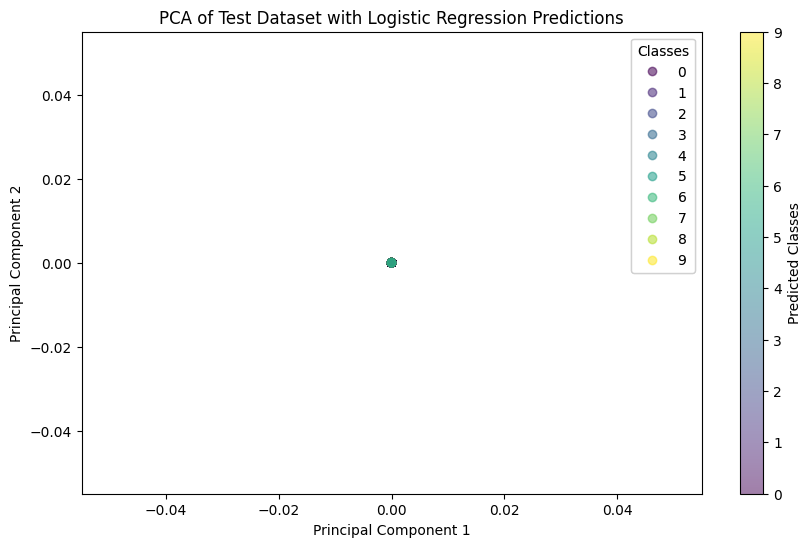

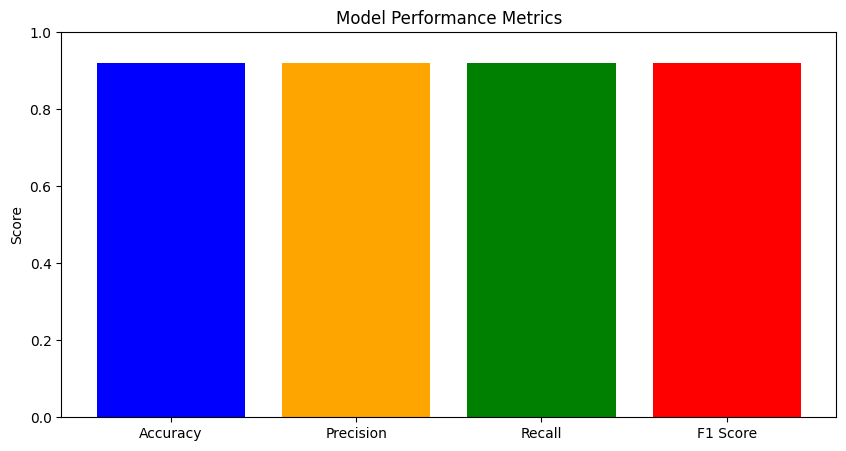

In [26]:
train_images_flat, test_images_flat = flatten_images(train_images, test_images)
log_reg_model_without_Preprocessed_images = train_log_reg(train_images_flat, train_labels)
predictions = evaluate_log_reg(log_reg_model_without_Preprocessed_images, test_images_flat, test_labels)

### With Preprocessing 

Model Accuracy: 0.9265
Model Precision: 0.9264
Model Recall: 0.9265
Model F1 Score: 0.9264

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.97      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.93      0.94      0.94       982
           5       0.91      0.87      0.89       892
           6       0.95      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.87      0.89      0.88       974
           9       0.92      0.91      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



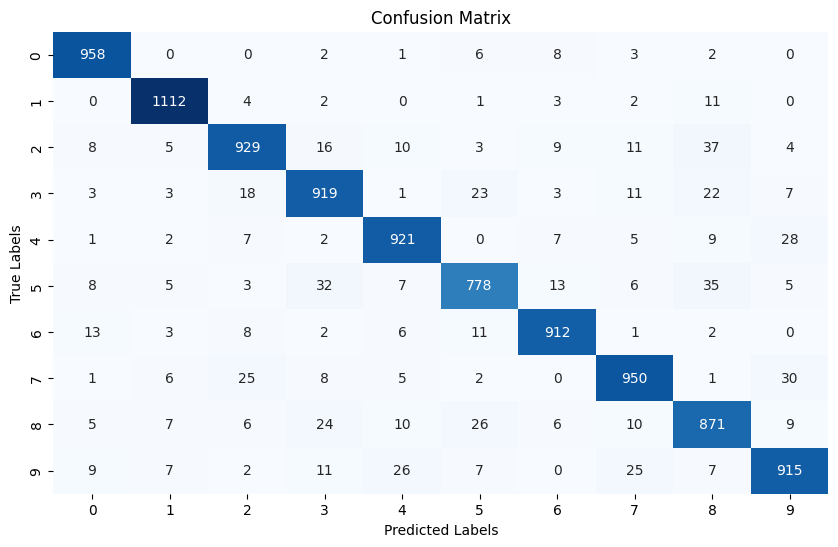

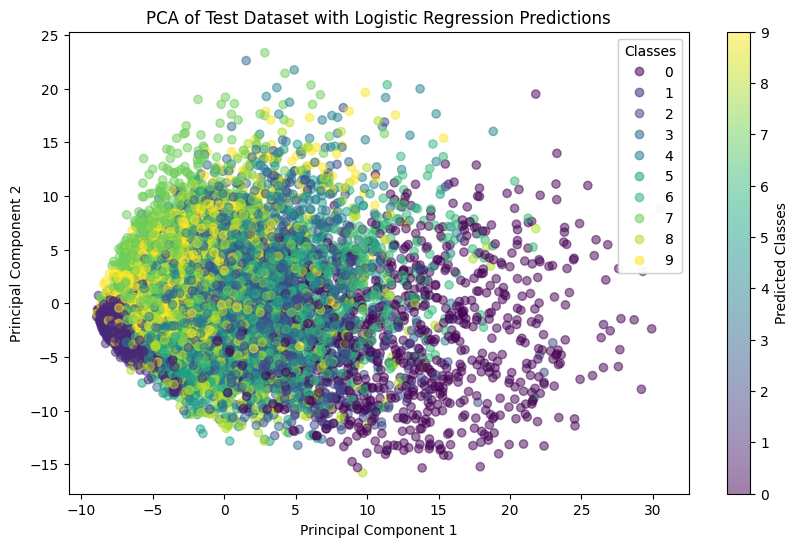

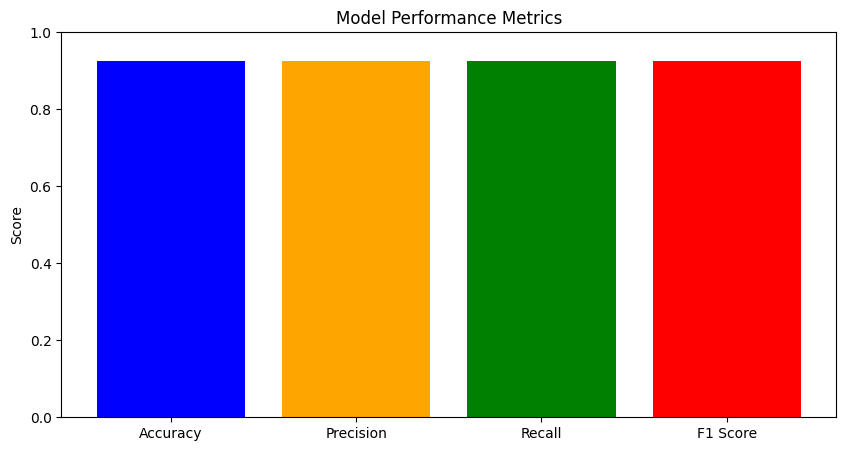

In [27]:
log_reg_model_with_Preprocessed_images = train_log_reg(preprosess_train_images, train_labels)
predictions = evaluate_log_reg(log_reg_model_with_Preprocessed_images, preprocess_test_images, test_labels)

# ----------------------------PArt B Using Optimizers ---------------------

### using SGD

Model Accuracy: 0.9239
Model Precision: 0.9237
Model Recall: 0.9239
Model F1 Score: 0.9237

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.94      0.90      0.92      1032
           3       0.91      0.91      0.91      1010
           4       0.93      0.93      0.93       982
           5       0.91      0.87      0.89       892
           6       0.93      0.95      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.90      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



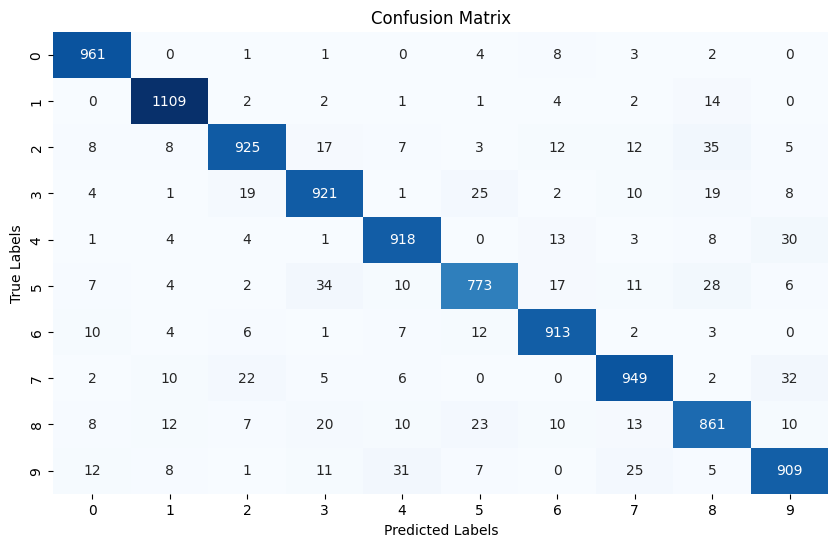

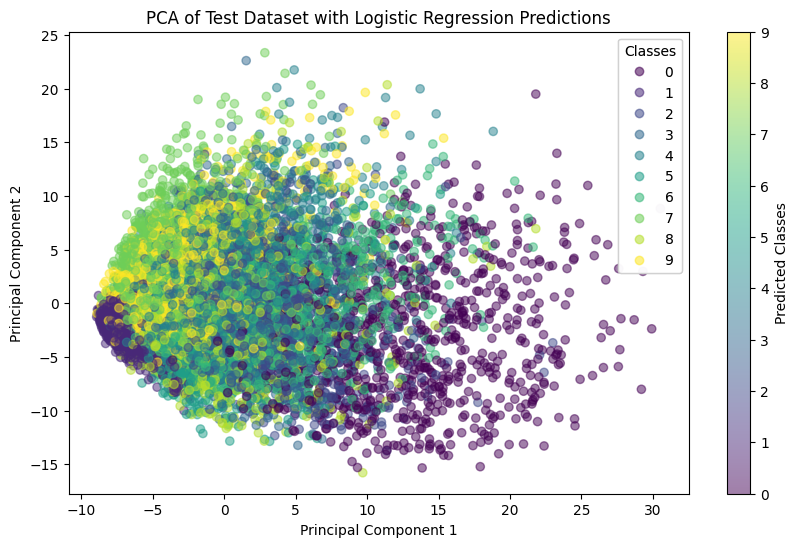

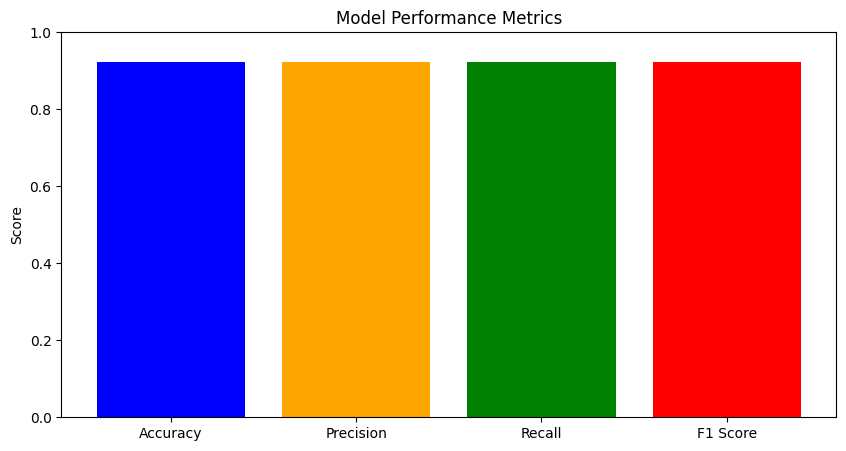

In [29]:
log_reg_model_SGD_with_Preprocessed_images = train_log_reg(preprosess_train_images, train_labels, optimizer='saga')
predictions = evaluate_log_reg(log_reg_model_SGD_with_Preprocessed_images, preprocess_test_images, test_labels)


### Using RMSprop 10 epocs

Epoch 1/10


c:\Users\mahma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7336 - loss: 0.9833
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9154 - loss: 0.3142
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9201 - loss: 0.2914
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9230 - loss: 0.2823
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9256 - loss: 0.2815
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9258 - loss: 0.2724
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9275 - loss: 0.2686
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9255 - loss: 0.2702
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9256 - loss: 0.2669
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9274 - loss: 0.2727
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model Accuracy: 0.9263
Model Precision: 0.9263
Model Recall: 0.9263
Model F1 Score: 0.926

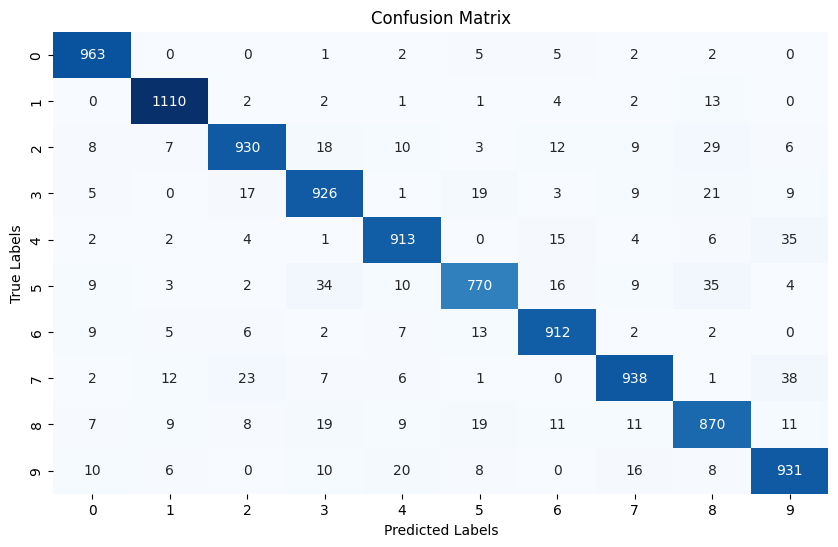

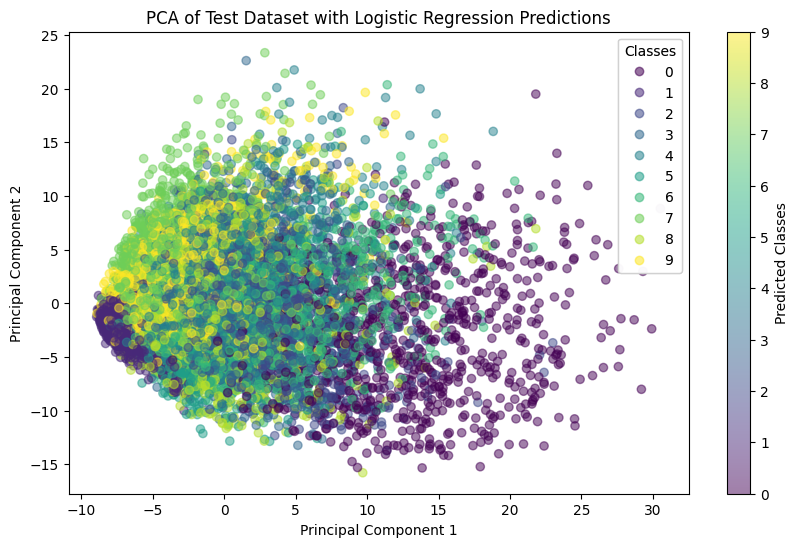

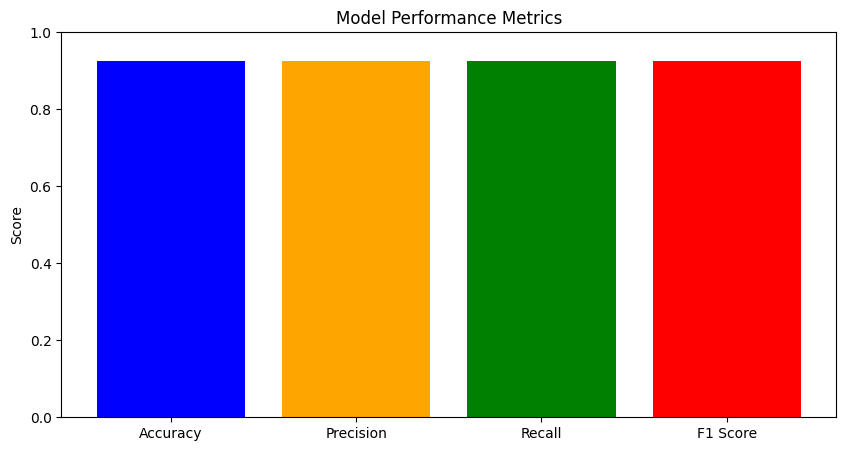

In [36]:
log_reg_model_rmsprop__with_Preprocessed_images = train_log_reg(preprosess_train_images, train_labels, optimizer='rmsprop', use_tensorflow=True, epochs=10)
predictions = evaluate_log_reg(log_reg_model_rmsprop__with_Preprocessed_images, preprocess_test_images, test_labels, use_tensorflow=True)


### Using RMSprop 100 epocs

Epoch 1/100


c:\Users\mahma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7275 - loss: 0.9933
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9168 - loss: 0.3188
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9198 - loss: 0.2975
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9248 - loss: 0.2775
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9257 - loss: 0.2729
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9270 - loss: 0.2679
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9262 - loss: 0.2759
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9247 - loss: 0.2695
Epoch 9/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9278 - loss: 0.2626
Epoch 10/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9262 - loss: 0.2658
Epoch 11/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9280 - loss: 0.2630
Epoch 12/100
1875/1875 ━━━━━━━━

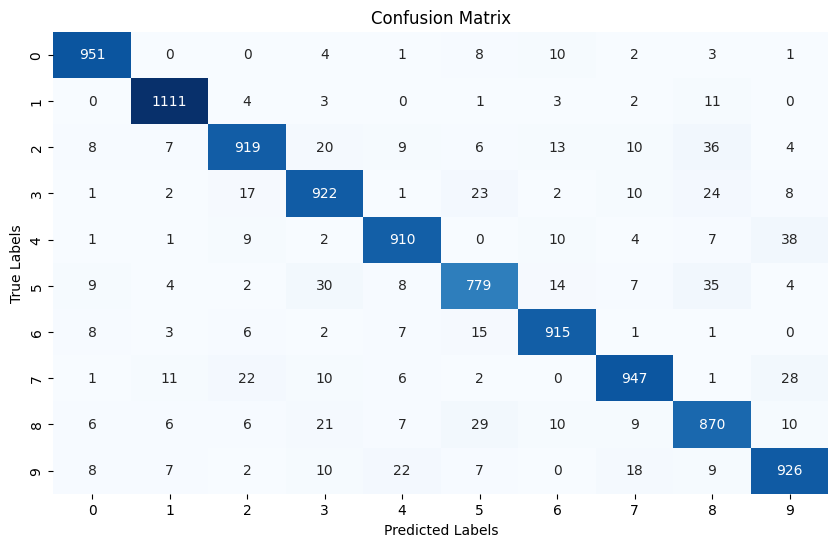

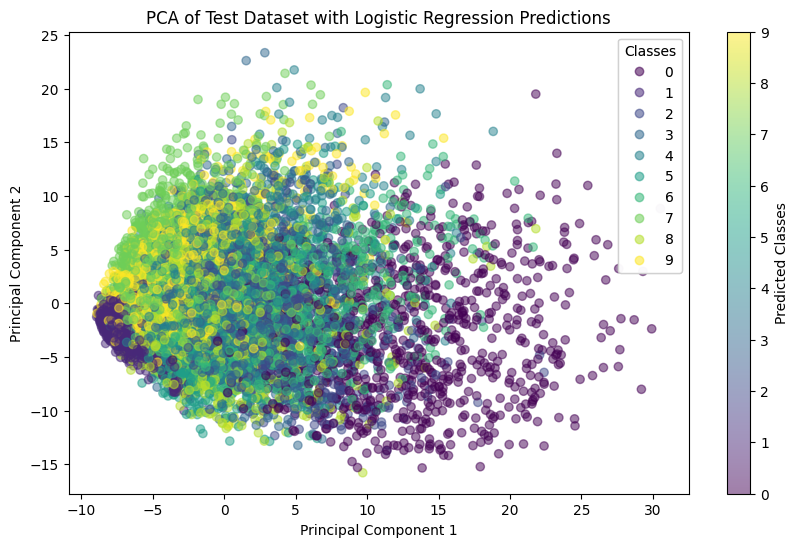

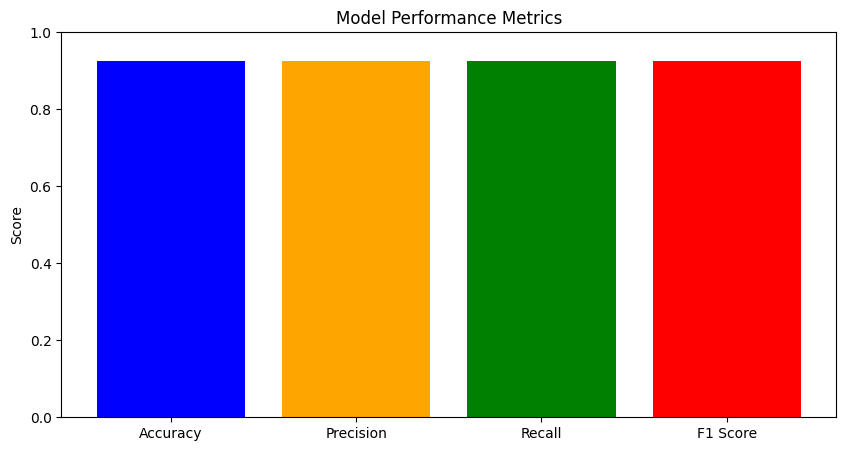

In [37]:
log_reg_model_rmsprop__with_Preprocessed_images = train_log_reg(preprosess_train_images, train_labels, optimizer='rmsprop', use_tensorflow=True, epochs=100)
predictions = evaluate_log_reg(log_reg_model_rmsprop__with_Preprocessed_images, preprocess_test_images, test_labels, use_tensorflow=True)

### Using ADAM 10 epocs

Epoch 1/10


c:\Users\mahma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6931 - loss: 1.1363
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9140 - loss: 0.3188
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9203 - loss: 0.2874
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9228 - loss: 0.2780
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9230 - loss: 0.2764
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9263 - loss: 0.2669
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9241 - loss: 0.2781
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9254 - loss: 0.2718
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9282 - loss: 0.2618
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9283 - loss: 0.2658
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model Accuracy: 0.9250
Model Precision: 0.9249
Model Recall: 0.9250
Model F1 Score: 0.924

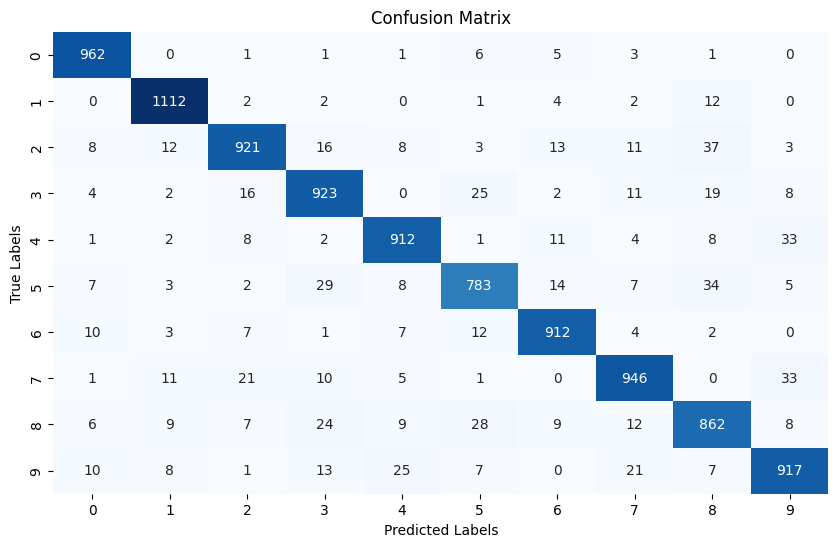

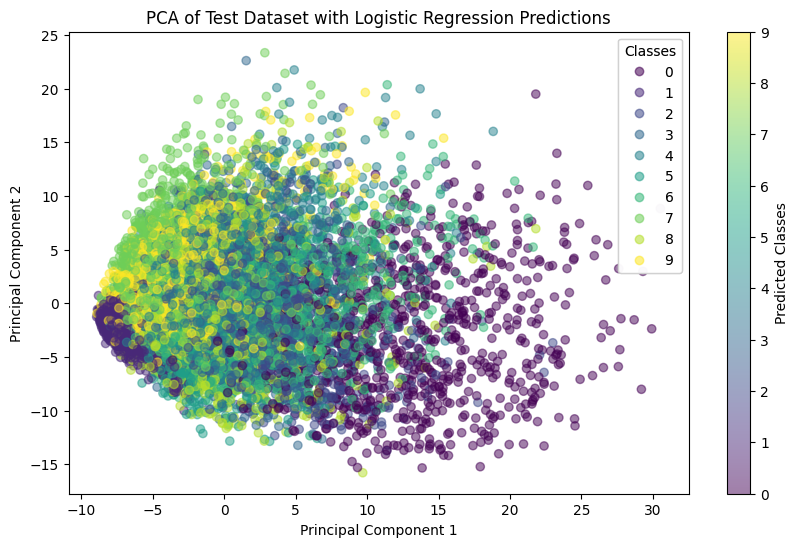

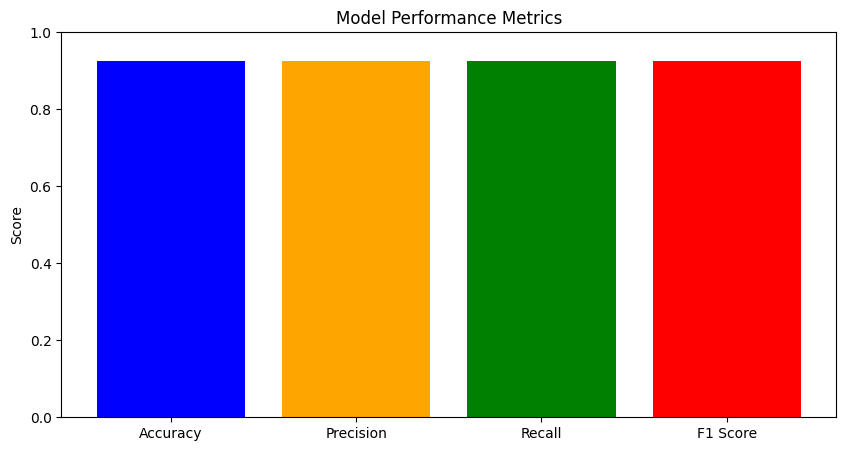

In [38]:
log_reg_model_adam_with_Preprocessed_images = train_log_reg( preprosess_train_images, train_labels,optimizer='adam', use_tensorflow=True,epochs=10  )
predictions = evaluate_log_reg(log_reg_model_adam_with_Preprocessed_images, preprocess_test_images, test_labels, use_tensorflow=True)

### Using ADAM 100 epocs

Epoch 1/100


c:\Users\mahma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6775 - loss: 1.1941
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9143 - loss: 0.3147
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9201 - loss: 0.2879
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9208 - loss: 0.2840
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9242 - loss: 0.2753
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9264 - loss: 0.2688
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9293 - loss: 0.2607
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9272 - loss: 0.2604
Epoch 9/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9264 - loss: 0.2755
Epoch 10/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9273 - loss: 0.2676
Epoch 11/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9289 - loss: 0.2614
Epoch 12/100
1875/1875 ━━━━━━━━

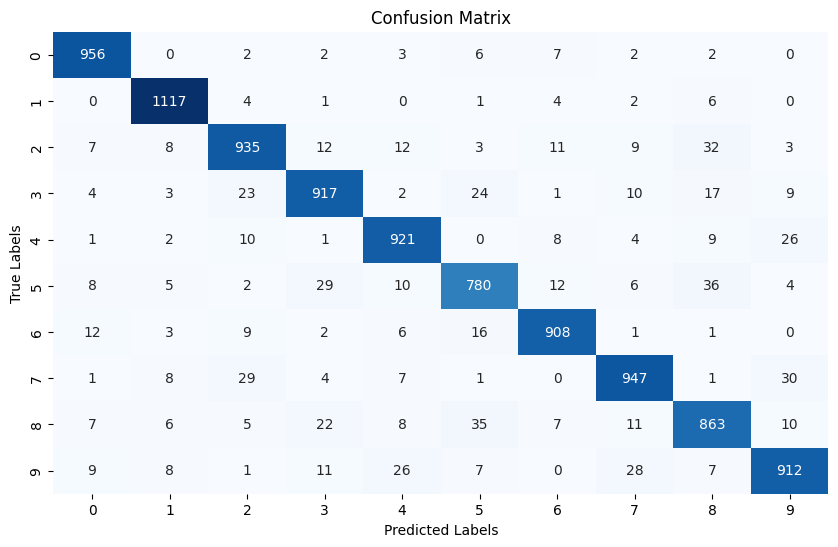

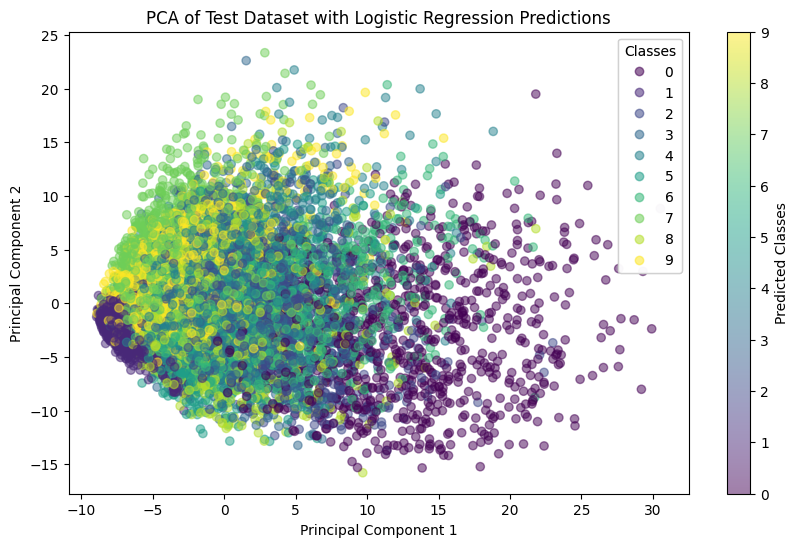

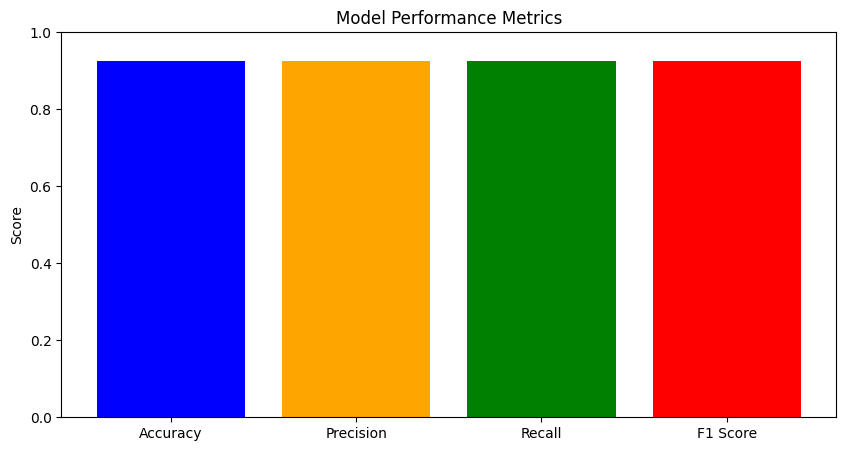

In [39]:
log_reg_model_adam_with_Preprocessed_images = train_log_reg( preprosess_train_images, train_labels,optimizer='adam', use_tensorflow=True,epochs=100  )
predictions = evaluate_log_reg(log_reg_model_adam_with_Preprocessed_images, preprocess_test_images, test_labels, use_tensorflow=True)

### using Nesterov Accelerated Gradient with 100 epochs

Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7697 - loss: 0.8102
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9058 - loss: 0.3389
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9147 - loss: 0.3054
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9191 - loss: 0.2930
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9215 - loss: 0.2799
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9231 - loss: 0.2782
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9258 - loss: 0.2657
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9239 - loss: 0.2725
Epoch 9/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9261 - loss: 0.2685
Epoch 10/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9249 - loss: 0.2661
Epoch 11/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9259 - loss: 0.2690
Epoch 12/100
1875/1

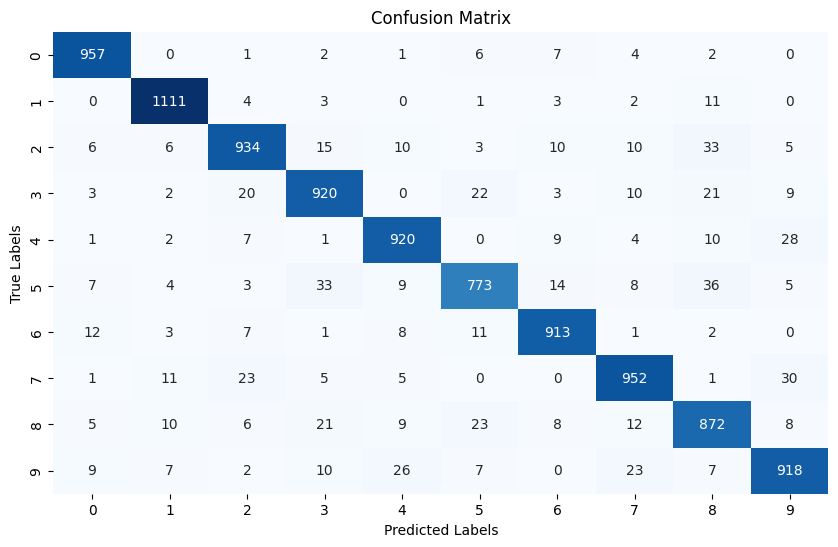

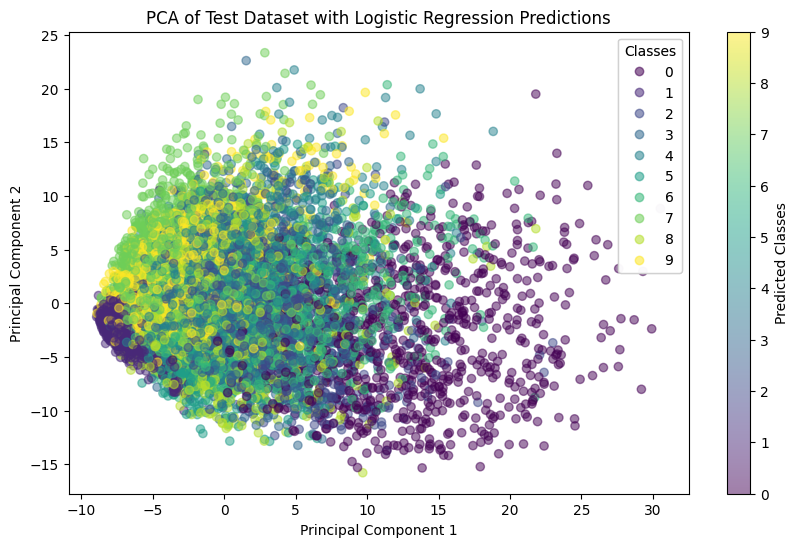

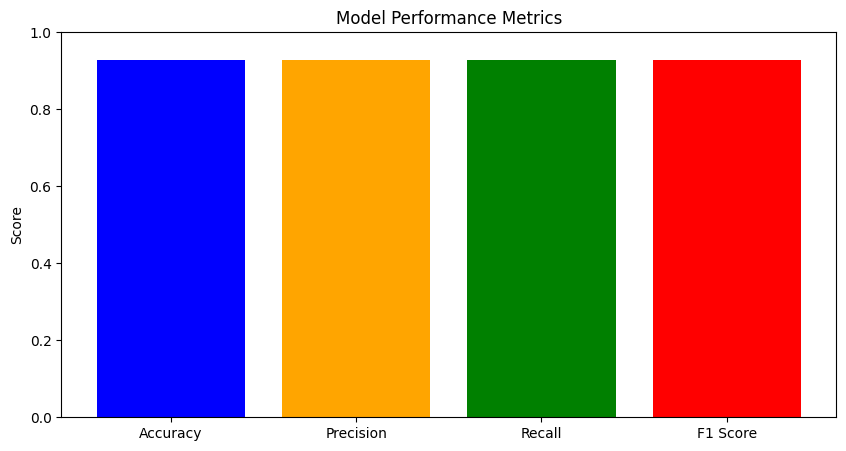

In [44]:
log_reg_model_nag_with_Preprocessed_images = train_log_reg(preprosess_train_images,train_labels,optimizer='nag', use_tensorflow=True,epochs=100)
predictions = evaluate_log_reg(log_reg_model_nag_with_Preprocessed_images, preprocess_test_images, test_labels, use_tensorflow=True)

# --------------------------Part C hyperparameter tuning-----------------------

In [54]:
def model_builder(hp):
    #  hyperparameters from KerasTuner
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='LOG')
    epochs = hp.Int('epochs', min_value=5, max_value=100, step=5)
    batch_size = hp.Int('batch_size', min_value=16, max_value=128, step=16)
    model = train_log_reg(preprosess_train_images, train_labels, optimizer='adam', 
                          use_tensorflow=True, epochs=epochs, learning_rate=learning_rate)

    return model

### Create Vlidation set

In [85]:
val_split = 0.2  
split_index = int((1 - val_split) * len(preprosess_train_images))
train_images_hp, val_images_hp = preprosess_train_images[:split_index], preprosess_train_images[split_index:]
train_labels_hp, val_labels_hp = train_labels[:split_index], train_labels[split_index:]
print("Total samples in preprocessed training images:", preprosess_train_images.shape[0])
print("Total samples in training labels:", train_labels.shape[0])

Total samples in preprocessed training images: 60000
Total samples in training labels: 60000


### Run Tuner

In [89]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=100,
    factor=3,
    directory='my_dir',
    project_name='log_reg_tuning'
)
tuner.search(train_images_hp, train_labels_hp,
             epochs=100,
             batch_size=32,
             validation_data=(val_images_hp, val_labels_hp))

# Retrieve the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Output the best hyperparameters
print("Best Hyperparameters:")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")
print(f"Number of Epochs: {best_hyperparameters.get('epochs')}")
print(f"Batch Size: {best_hyperparameters.get('batch_size')}")

Trial 154 Complete [00h 02m 02s]
val_accuracy: 0.9026666879653931

Best val_accuracy So Far: 0.9401666522026062
Total elapsed time: 13h 44m 55s

Search: Running Trial #155

Value             |Best Value So Far |Hyperparameter
0.0001823         |0.00019761        |learning_rate
70                |100               |epochs
128               |16                |batch_size
4                 |4                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/70
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.3365 - loss: 2.4546
Epoch 2/70
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8465 - loss: 0.6158
Epoch 3/70
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8921 - loss: 0.4181
Epoch 4/70
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9077 - loss: 0.3490
Epoch 5/70
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy

KeyboardInterrupt: 

Loading best model and hyperparameters from saved trials...
Epoch 1/100


c:\Users\mahma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4535 - loss: 1.9076
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8629 - loss: 0.5471
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8949 - loss: 0.3962
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9077 - loss: 0.3374
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9134 - loss: 0.3127
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9170 - loss: 0.2928
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 940us/step - accuracy: 0.9217 - loss: 0.2864
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 923us/step - accuracy: 0.9230 - loss: 0.2771
Epoch 9/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9245 - loss: 0.2726
Epoch 10/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9268 - loss: 0.2656
Epoch 11/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9251 - loss: 0.2674
Epoch 12/100
1875/1875 ━━━━

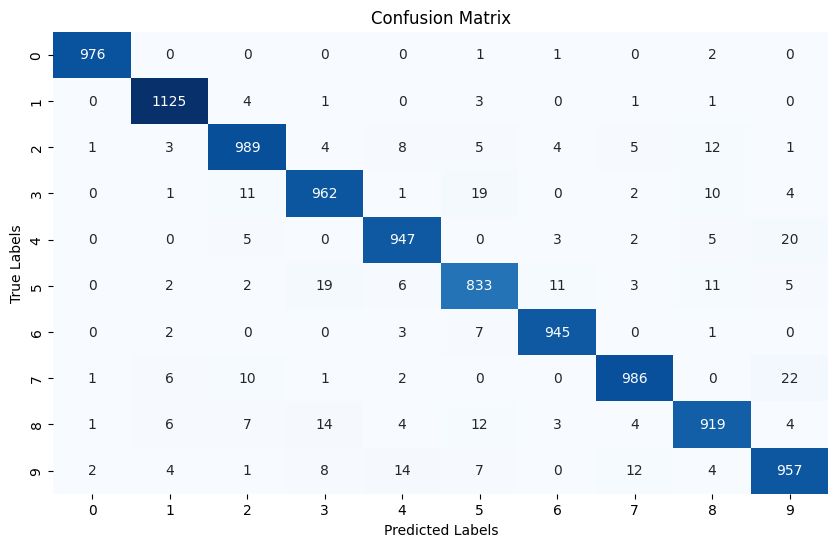

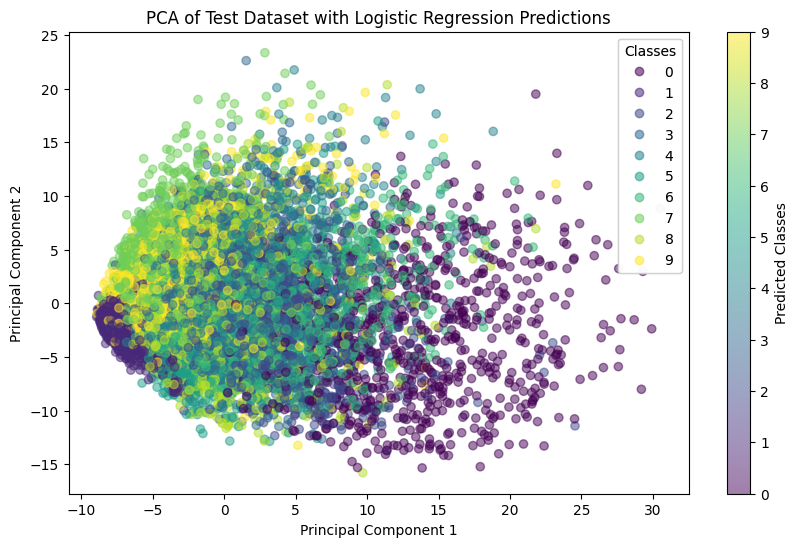

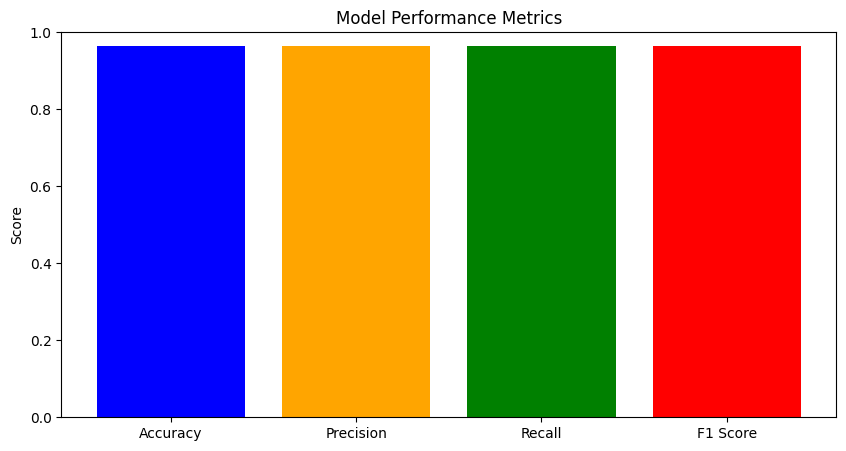

Predictions on test set from the best saved model:
(0.9639, array([7, 2, 1, ..., 4, 5, 6], dtype=int64))


In [91]:
print("Loading best model and hyperparameters from saved trials...")

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters from saved trials:")
learning_rate = best_hyperparameters.get('learning_rate')
epochs = best_hyperparameters.get('epochs')
batch_size = best_hyperparameters.get('batch_size')

print(f"Learning Rate: {learning_rate}")
print(f"Number of Epochs: {epochs}")
print(f"Batch Size: {batch_size}")
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
best_model.fit(
    preprocess_test_images, 
    test_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(preprocess_test_images, test_labels), 
    verbose=2
)
predictions = evaluate_log_reg(best_model, preprocess_test_images, test_labels, use_tensorflow=True)

print("Predictions on test set from the best saved model:")
print(predictions)